In [1]:
import example1
import pdp

import math
import numpy as np
import qutip as qt
from qutip.solver.heom import HEOMSolver, UnderDampedBath

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
ex1 = example1.setup_example()

FOLDER_NAME = '/mnt/c/calc_results/'

### Calculation by integrating master equation

In [3]:
liouvillian = -1j * qt.spre(ex1['Htot']) + 1j * qt.spost(ex1['Htot'])
for gamma, L in zip(ex1['rates'], ex1['lindblad_ops']):
    liouvillian += gamma * (qt.spre(L) * qt.spost(L.dag()) - qt.spre(L.dag() * L) / 2 - qt.spost(L.dag() * L) / 2)

mesol = qt.mesolve(liouvillian, ex1['rho0'], example1.TLIST, e_ops=[ex1['Hs'], *ex1['heat_current_ops']],
                   options={'normalize_output': False, 'progress_bar': 'tqdm'})

  0%|          | 0/249 [00:00<?, ?it/s]

### Calculation with HEOM

In [4]:
HEOM_CUTOFF = 15

In [5]:
def bath_heat_current(time, ado_state):
    # copied, modified from qutip-tutorials notebook
    l1_labels = ado_state.filter(level=1)

    result = 0
    for label in l1_labels:
        [exp] = ado_state.exps(label)
        result += exp.vk * (ex1['Q_system'] * ado_state.extract(label)).tr()

    return np.real(result)

In [6]:
bath = UnderDampedBath(ex1['Q_system'],
                       example1.COUP_STRENGTH, 2 * example1.HALF_WIDTH, example1.BATH_FREQ, 1 / example1.BETA,
                       example1.NUM_MATSUBARA)
solver = HEOMSolver(ex1['Hs_system'], bath, HEOM_CUTOFF,
                    options={'progress_bar': 'tqdm'})

heomsol = solver.run(ex1['rho0_system'], example1.TLIST, e_ops=[ex1['Hs_system'], bath_heat_current])

  0%|          | 0/249 [00:00<?, ?it/s]

### Time Evolution

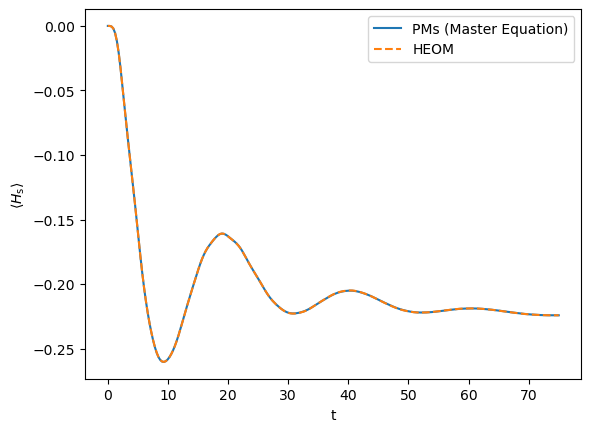

In [7]:
plt.plot(example1.TLIST, mesol.expect[0], label='PMs (Master Equation)')
plt.plot(example1.TLIST, heomsol.expect[0], '--', label='HEOM')
plt.xlabel('t')
plt.ylabel(r'$\langle H_{\text{s}} \rangle$')

plt.legend()
plt.show()

### Heat Currents

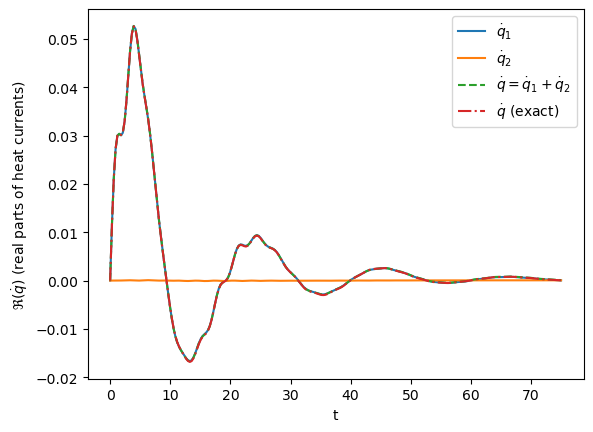

In [8]:
plt.plot(example1.TLIST, np.real(mesol.expect[1]), label=r'$\dot q_1$')
plt.plot(example1.TLIST, np.real(mesol.expect[2]), label=r'$\dot q_2$')
plt.plot(example1.TLIST, np.real(mesol.expect[1]) + np.real(mesol.expect[2]), '--', label=r'$\dot q = \dot q_1 + \dot q_2$')
plt.plot(example1.TLIST, np.real(heomsol.expect[1]), '-.', label=r'$\dot q$ (exact)')
plt.xlabel('t')
plt.ylabel(r'$\Re(\dot q)$ (real parts of heat currents)')

plt.legend()
plt.show()

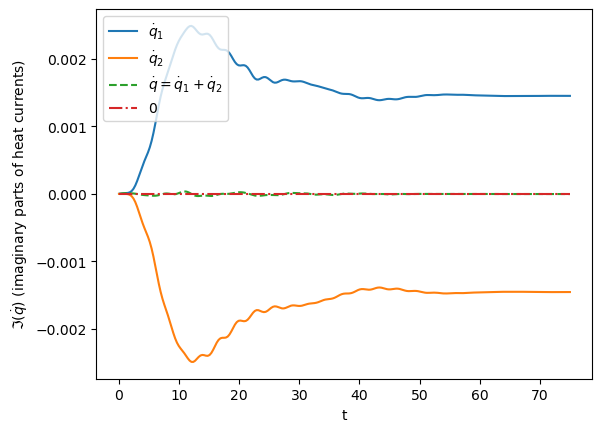

In [9]:
plt.plot(example1.TLIST, np.imag(mesol.expect[1]), label=r'$\dot q_1$')
plt.plot(example1.TLIST, np.imag(mesol.expect[2]), label=r'$\dot q_2$')
plt.plot(example1.TLIST, np.imag(mesol.expect[1]) + np.imag(mesol.expect[2]), '--', label=r'$\dot q = \dot q_1 + \dot q_2$')
plt.plot(example1.TLIST, np.zeros_like(example1.TLIST), '-.', label='$0$')
plt.xlabel('t')
plt.ylabel(r'$\Im(\dot q)$ (imaginary parts of heat currents)')

plt.legend()
plt.show()

### Trajectories

In [10]:
mcsol1 = qt.qload(FOLDER_NAME + 'result-0-AlternativePseudoUnraveling')
mcsol2 = qt.qload(FOLDER_NAME + 'result-0-StandardPseudoUnraveling')
mcsol3 = qt.qload(FOLDER_NAME + 'result-0-UnravelingLikeAppendixC4')
mcsol4 = qt.qload(FOLDER_NAME + 'result-0-BreuerUnraveling')

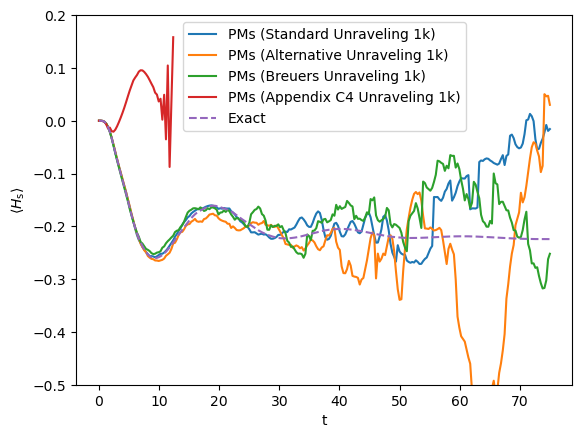

In [11]:
plt.plot(example1.TLIST, np.real(mcsol2.average_expect[0]), label='PMs (Standard Unraveling 1k)')
plt.plot(example1.TLIST, np.real(mcsol1.average_expect[0]), label='PMs (Alternative Unraveling 1k)')
plt.plot(example1.TLIST, np.real(mcsol4.average_expect[0]), label="PMs (Breuers Unraveling 1k)")
plt.plot(example1.TLIST[:42], np.real(mcsol3.average_expect[0])[:42], label='PMs (Appendix C4 Unraveling 1k)')
plt.plot(example1.TLIST, np.real(heomsol.expect[0]), '--', label='Exact')
plt.xlabel('t')
plt.ylabel(r'$\langle H_{\text{s}} \rangle$')
plt.ylim((-.5, .2))

plt.legend()
plt.show()

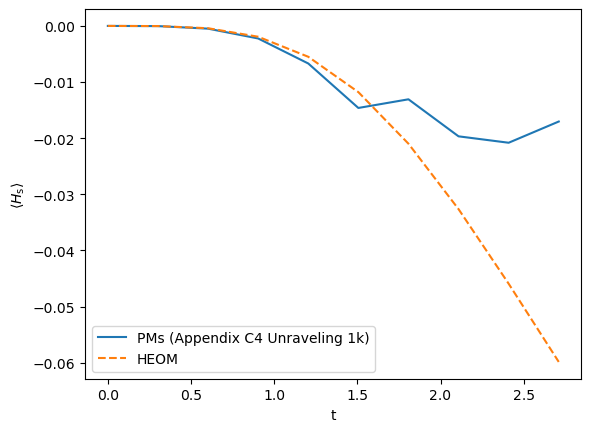

In [12]:
plt.plot(example1.TLIST[:10], np.real(mcsol3.average_expect[0])[:10], label='PMs (Appendix C4 Unraveling 1k)')
plt.plot(example1.TLIST[:10], np.real(heomsol.expect[0])[:10], '--', label='HEOM')
plt.xlabel('t')
plt.ylabel(r'$\langle H_{\text{s}} \rangle$')

plt.legend()
plt.show()

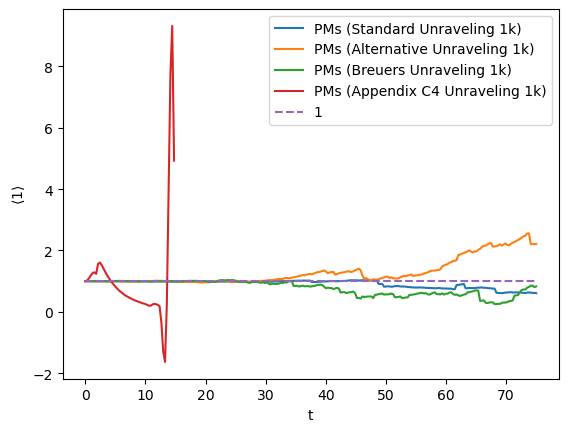

In [13]:
plt.plot(example1.TLIST, np.real(mcsol2.average_expect[1]), label='PMs (Standard Unraveling 1k)')
plt.plot(example1.TLIST, np.real(mcsol1.average_expect[1]), label='PMs (Alternative Unraveling 1k)')
plt.plot(example1.TLIST, np.real(mcsol4.average_expect[1]), label="PMs (Breuers Unraveling 1k)")
plt.plot(example1.TLIST[:50], np.real(mcsol3.average_expect[1])[:50], label='PMs (Appendix C4 Unraveling 1k)')
plt.plot(example1.TLIST, np.ones_like(example1.TLIST), '--', label='1')
plt.xlabel('t')
plt.ylabel(r'$\langle 1 \rangle$')

plt.legend()
plt.show()

### Final Plots

In [14]:
from mpl_setup import *  # noqa: E402, F403

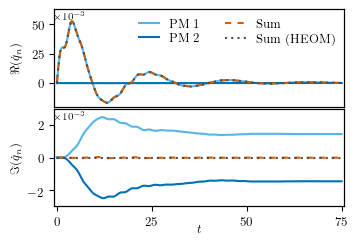

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1)

axes[0].plot(example1.TLIST, np.real(mesol.expect[1]), color=SKY_BLUE, label=r'PM 1')
axes[0].plot(example1.TLIST, np.real(mesol.expect[2]), color=BLUE, label=r'PM 2')
axes[0].plot(example1.TLIST, np.real(mesol.expect[1]) + np.real(mesol.expect[2]), '--', color=VERMILLION, label=r'Sum')
axes[0].plot(example1.TLIST, np.real(heomsol.expect[1]), ':', color=GRAY, label=r'Sum (HEOM)')

axes[0].set_xlim((-.75, 75.75))
axes[0].set_xlabel(None)
axes[0].set_xticks([])

axes[0].set_ylim((-0.02, 0.063))
axes[0].set_ylabel(r'$\Re(\dot q_n)$')
axes[0].set_yticks([0, 0.025, 0.05], labels=[r'$0$', r'$25$', r'$50$'])

axes[0].legend(loc='upper right', ncols=2)

top_axis = axes[0].twiny()
top_axis.set_xlabel(r'\scriptsize $\times 10^{-3}$', labelpad=-7, loc='left')
top_axis.set_xticks([])

axes[1].plot(example1.TLIST, np.imag(mesol.expect[1]), color=SKY_BLUE, label=r'PM 1')
axes[1].plot(example1.TLIST, np.imag(mesol.expect[2]), color=BLUE, label=r'PM 2')
axes[1].plot(example1.TLIST, np.imag(mesol.expect[1]) + np.imag(mesol.expect[2]), '--', color=VERMILLION, label=r'Sum')
axes[1].plot(example1.TLIST, np.zeros_like(example1.TLIST), ':', color=GRAY, label=r'Sum (HEOM)')

axes[1].set_xlim((-.75, 75.75))
axes[1].set_xlabel(r'$t$', labelpad=-3)
axes[1].set_xticks([0, 25, 50, 75], labels=[r'$0$', r'$25$', r'$50$', r'$75$'])

axes[1].set_ylim((-0.003, 0.003))
axes[1].set_ylabel(r'$\Im(\dot q_n)$')
axes[1].set_yticks([-0.002, 0, 0.002], labels=[r'$-2$', r'$0$', r'$2$'])

top_axis2 = axes[1].twiny()
top_axis2.set_xlabel(r'\scriptsize $\times 10^{-3}$', labelpad=-7, loc='left')
top_axis2.set_xticks([])

fig.align_ylabels()

plt.savefig('../ex1_heat_currents.pdf')
plt.show()

In [15]:
results = {
    pdp.StandardPseudoUnraveling: [],
    pdp.AlternativePseudoUnraveling: [],
    pdp.BreuerUnraveling: [],
    pdp.UnravelingLikeAppendixC4: [],
}

for i in range(0, 536):
    results[pdp.StandardPseudoUnraveling].append(qt.qload(FOLDER_NAME + f'result-{i}-StandardPseudoUnraveling'))
    results[pdp.AlternativePseudoUnraveling].append(qt.qload(FOLDER_NAME + f'result-{i}-AlternativePseudoUnraveling'))
    results[pdp.BreuerUnraveling].append(qt.qload(FOLDER_NAME + f'result-{i}-BreuerUnraveling'))
    results[pdp.UnravelingLikeAppendixC4].append(qt.qload(FOLDER_NAME + f'result-{i}-UnravelingLikeAppendixC4'))

In [16]:
result1k = results[pdp.StandardPseudoUnraveling][0]
result10k = sum(results[pdp.StandardPseudoUnraveling][1:10], result1k)
result100k = sum(results[pdp.StandardPseudoUnraveling][10:100], result10k)

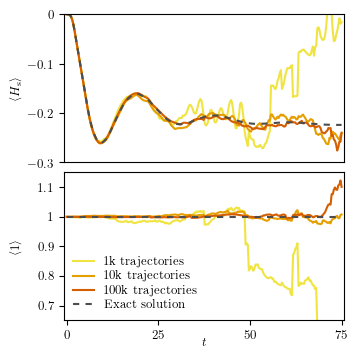

In [19]:
square_size = [matplotlib.rcParams['figure.figsize'][0]] * 2
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=square_size)

axes[0].plot(example1.TLIST, np.real(result1k.average_expect[0]), color=YELLOW, label=r'1k')
axes[0].plot(example1.TLIST, np.real(result10k.average_expect[0]), color=ORANGE, label=r'10k')
axes[0].plot(example1.TLIST, np.real(result100k.average_expect[0]), color=VERMILLION, label=r'100k')
axes[0].plot(example1.TLIST, heomsol.expect[0], '--', color=GRAY, label=r'Exact')

axes[0].set_xlim((-.75, 75.75))
axes[0].set_xlabel(None)
axes[0].set_xticks([])

axes[0].set_ylim((-0.3, 0))
axes[0].set_ylabel(r'$\langle H_{\textrm{s}} \rangle$')
axes[0].set_yticks(ticks=[-.3, -.2, -.1, 0], labels=[r'$-0.3$', r'$-0.2$', r'$-0.1$', r'$0$'])

axes[1].plot(example1.TLIST, np.real(result1k.average_expect[1]), color=YELLOW, label=r'1k trajectories')
axes[1].plot(example1.TLIST, np.real(result10k.average_expect[1]), color=ORANGE, label=r'10k trajectories')
axes[1].plot(example1.TLIST, np.real(result100k.average_expect[1]), color=VERMILLION, label=r'100k trajectories')
axes[1].plot(example1.TLIST, np.ones_like(example1.TLIST), '--', color=GRAY, label=r'Exact solution')

axes[1].set_xlim((-.75, 75.75))
axes[1].set_xlabel(r'$t$', labelpad=-3)
axes[1].set_xticks([0, 25, 50, 75], labels=[r'$0$', r'$25$', r'$50$', r'$75$'])

axes[1].set_ylim((0.65, 1.15))
axes[1].set_ylabel(r'$\langle 1 \rangle$')
axes[1].set_yticks([0.7, 0.8, 0.9, 1, 1.1], labels=[r'$0.7$', r'$0.8$', r'$0.9$', r'$1$', r'$1.1$'])

axes[1].legend(loc='lower left', ncols=1)

fig.align_ylabels()

plt.savefig('../ex1_trajectories.pdf')
plt.show()

In [17]:
THRESHOLD = 1e-2

analysis = {unraveling: {} for unraveling in results.keys()}

for unraveling in results.keys():
    print(unraveling)

    bunches_1k = results[unraveling]
    num_bunches = len(bunches_1k)
#    for package_size in range(1, num_bunches):
    for package_size in range(1, 100):
        good_percentage = []
        for i in range(math.floor(num_bunches / package_size)):
            package = bunches_1k[(package_size * i):(package_size * (i+1))]
            package_average = sum(package[1:], start=package[0])
            good_num = np.count_nonzero(
                np.isclose(package_average.average_expect[0], heomsol.expect[0], rtol=0, atol=THRESHOLD)
#                np.isclose(package_average.average_expect[1], np.ones_like(example1.TLIST), rtol=0, atol=THRESHOLD)
            )
            good_percentage.append(good_num / len(example1.TLIST))
            
        analysis[unraveling].update({package_size: good_percentage})

<class 'pdp.pseudomodes.StandardPseudoUnraveling'>
<class 'pdp.pseudomodes.AlternativePseudoUnraveling'>
<class 'pdp.pseudomodes.BreuerUnraveling'>
<class 'pdp.pseudomodes.UnravelingLikeAppendixC4'>


In [18]:
xs = list(analysis[pdp.StandardPseudoUnraveling].keys())
ys_standard = [np.average(v) for v in analysis[pdp.StandardPseudoUnraveling].values()]
ys_alt = [np.average(v) for v in analysis[pdp.AlternativePseudoUnraveling].values()]
ys_breuer = [np.average(v) for v in analysis[pdp.BreuerUnraveling].values()]
ys_c4 = [np.average(v) for v in analysis[pdp.UnravelingLikeAppendixC4].values()]

c4_1k = results[pdp.UnravelingLikeAppendixC4][0]
c4_10k = sum(results[pdp.UnravelingLikeAppendixC4][1:10], c4_1k)
c4_500k = sum(results[pdp.UnravelingLikeAppendixC4][10:500], c4_10k)

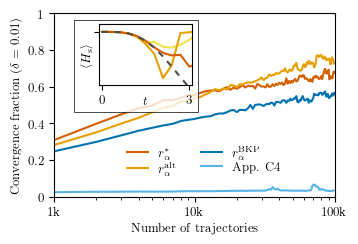

In [20]:
fig, ax = plt.subplots()

ax.plot(xs, ys_standard, color=VERMILLION, label=r'$r_\alpha^\ast$')
ax.plot(xs, ys_alt, color=ORANGE, label=r'$r_\alpha^{\mathrm{alt}}$')
ax.plot(xs, ys_breuer, color=BLUE, label=r'$r_\alpha^{\mathrm{BKP}}$')
ax.plot(xs, ys_c4, color=SKY_BLUE, label='App. C4')

ax.set_xscale('log')
ax.set_xlim((xs[0], xs[-1]))
ax.set_xlabel('Number of trajectories')
ax.set_xticks([1, 10, 100], labels=[r'$1$k', r'$10$k', r'$100$k'])

ax.set_ylim((0, 1))
ax.set_ylabel(f'Convergence fraction ($\\delta = {THRESHOLD}$)')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], labels=[r'$0$', r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1$'])

ax.legend(loc=(0.25, 0.1), ncols=2)

ax2 = ax.inset_axes([0.16, 0.61, 0.33, 0.33])
ax2.plot(example1.TLIST[:15], np.real(c4_1k.average_expect[0])[:15], color=YELLOW)
ax2.plot(example1.TLIST[:15], np.real(c4_10k.average_expect[0])[:15], color=ORANGE)
ax2.plot(example1.TLIST[:15], np.real(c4_500k.average_expect[0])[:15], color=VERMILLION)
ax2.plot(example1.TLIST[:15], np.real(heomsol.expect[0])[:15], '--', color=GRAY)
ax2.set_xlabel(r'$t$', labelpad=-7)
ax2.set_xlim((-.1, 3.1))
ax2.set_xticks([0, 3], labels=[r'$0$', r'$3$'])
ax2.set_ylabel(r'$\langle H_{\textrm{s}} \rangle$', labelpad=-3)
ax2.set_ylim((-0.07, 0.01))
ax2.set_yticks([0], labels=[''])

trafo = ax2.transAxes
box = ax2.get_tightbbox().transformed(trafo.inverted()).extents
x, y, w, h = box[0], box[1], (box[2] - box[0]), (box[3] - box[1])
ax.add_patch(Rectangle((x - w * 0.05, y - h * 0.05), w * 1.1, h * 1.1, transform=trafo, zorder=5,
                       facecolor=(1, 1, 1, 0.8), edgecolor='black', linestyle="-", linewidth=.5))
# are you serious matplotlib?

plt.savefig('../ex1_appendix.pdf')
plt.show()

In [38]:
c4_process = pdp.UnravelingLikeAppendixC4(ex1['Htot'], ex1['lindblad_ops'], ex1['rates'])
print(c4_process._Lambda)
print(np.log(500000) / c4_process._Lambda)

3.9021284808747523
3.362873222068446
